# Factor analysis using PEER

**FIXME: there is a file `Get_default_sets.R` in this directory. Please eliminate if it is not necessary** - Delected

**FIXME2: will wrap docker image tmr (current image: Baseline docker image is from: rtibiocloud/peer:1.3_8f2237f)**

## 1.Overview: 

This workflow is intend to perform [Probabilistic Estimation of Expression Residuals (PEER) method](https://github.com/PMBio/peer/wiki/Tutorial) , which is a standard part in GTEX protocal 

## 2.Input and output:

As we intend to make this module exchangeable with `APEX`, the input file in both workflow are same. Please refer [APEX input format](https://corbinq.github.io/apex/doc/input_files/) for other details. Here we just illustrate the minimum requirment in this workflow. 

#### Required input

* --expression_file: a `.bed` like file with following format. Please note that **no missing values** is allowed in molecular trait quantification. **In this workflow only**, first four coloum can be any informaion irrelvant (just designed for consistency with `APEX` workflow). 

In [48]:
readr::read_delim("PEER_example_data/Peer_example_data.bed",show_col_types= F)[1:3,1:8]

#chr,start,end,gene_name,Sample1,Sample2,Sample3,Sample4
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,100,Gene1,-1.627455,1.684725,-0.0807924,1.510522
1,100,200,Gene2,-12.626715,17.746163,-14.2519447,5.254536
1,199,300,Gene3,3.337390,-7.259074,6.2643526,-1.375911


#### Optional inputs

* --covariate: A matrix with `C + 1` rows for covariates and `S + 1` columnes for samples. **No missing value is allowed** 

In [49]:
readr::read_delim("PEER_example_data/Peer_example_cov.txt",show_col_types= F)[,1:8]

#ID,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cov1,1.6243454,-2.301539,1.462108,-1.0998913,-1.100619,-0.6837279,-0.6916608
Cov2,-0.6117564,1.744812,-2.060141,-0.1724282,1.144724,-0.1228902,-0.3967535


* --name: a string specify the name of main output file `{name}.PEER.cov`

* --N: Number of PEER factor used. Default value will be 0. Under default, Recommended PEER factors will be generated based on the suggestion of [GTEX](https://gtexportal.org/home/documentationPage) automatically. To obtain `N` used in this case, please see the `.stdout` file.

* Other parameters sepcified by PEER

## 3. Outputs:

#### Main outputs:

* `{name}.PEER.cov`: result for peer factor covariates


## 4. Useage:
```sos
    sos run Call_PEER.ipynb PEER \
        --expression_file Peer_example_data/Peer_example_data.txt \
        --covariate (optional) \
        --cwd /Users/albert29/Documents/Lab/Pipelines/Call_PEER/Output/ \
        --N 10
        ...
```

## Setup and global parameters:

In [42]:
[global]
# The output directory for generated files. MUST BE FULL PATH
parameter: wd = path
cwd = wd
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16384"
# Number of threads
parameter: numThreads = 8
# Software container option
parameter: container_apex = str
parameter: name = "peer_out"

# N PEER factors, If do not specify or specified as 0, default values suggested by 
# UCSC (based on different sample size) Will be used
parameter: N = 4
n_of_factor = N

# Default values from PEER:
## The number of max iteration

parameter: max_iter = 1000
iteration = max_iter
## Prior parameters
parameter: Alpha_a = 0.001
parameter: Alpha_b = 0.1
parameter: Eps_a = 0.1
parameter: Eps_b = 10.
## Tolarance parameters
parameter: tol = 0.001
parameter: var_tol = 1e-08
# The molecular phenotype matrix
parameter: molecular_pheno = path
expression_file = molecular_pheno
# The covariate file
parameter: covariate_file = path

# vcf Genotypy list, so that apex factor can run with covariate file input, requirment: vcf shall have the same sample as the cov and molecular phenotype
# parameter: genotype_list = path
parameter: genotype_list = "None"
# import pandas as pd
# import os
# vcf_file = pd.read_csv(genotype_list,sep = "\t")["dir"][0]

In [44]:
sos run PEER_factor.ipynb -h

usage: sos run PEER_factor.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  PEER

Global Workflow Options:
  --wd VAL (as path, required)
                        The output directory for generated files. MUST BE FULL
                        PATH
  --job-size 1 (as int)
                        For cluster jobs, number commands to run per job
  --walltime 5h
                        Wall clock time expected
  --mem 16384
                        Memory expected
  --numThreads 8 (as int)
                        Number of threads
  --container-apex VAL (as str, required)
                        Software container option
  --name 'peer_out'
  --N 4 (as int)
                        N PEE

In [ ]:
[PEER]
input: expression_file
output: f'{cwd}/{_input:bn}_diagnosis_plot.jpeg',
        f'{cwd}/{name}.PEER.cov'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: container=container_apex, expand= "${ }", stderr = f'{_output}.stderr', stdout = f'{_output}.stdout'
    library(peer)
  
    #### PLOTING FUNCTIONS: ####  
      
    ## Adapted from the source code of package: https://github.com/PMBio/peer/blob/40bc4b2cd92459ce42f44dfe279717436395f3f6/R/peer/R/plot.R 
  
  
    PEER_plotModel_adapted <- function(model){
        par(mfrow=c(2,1))
        bounds = PEER_getBounds(model)
        vars = PEER_getResidualVars(model)
        plot(bounds, type="l", col="red", lwd=2, xlab="Iterations", ylab="Lower bound")
        par(new=TRUE)
        plot(vars,,type="l",col="blue",xaxt="n",yaxt="n",xlab="",ylab="")
        axis(4)
        mtext("Residual variance",side=4,line=3)
        legend("right",col=c("red","blue"),lty=1,legend=c("Lower bound","Residual variance"))
        alpha = PEER_getAlpha(model)
        plot(alpha,xlab="Factors",ylab="Inverse variance of factor weights", type="b", col="blue", lwd=4, xaxp=c(1,length(alpha), length(alpha)-1))
    }
    
    WriteTable <- function(data, filename, index.name) {
      datafile <- file(filename, open = "wt")
      on.exit(close(datafile))
      header <- c(index.name, colnames(data))
      writeLines(paste0(header, collapse = "\t"), con = datafile, sep = "\n")
      write.table(data, datafile, sep = "\t", col.names = F, quote = F)
    }
  
    #### MAIN ####
    
  
    # Start analysis:
    model <- PEER()
    cat("PEER: loading expression data ... ")
    #pe <- file.path(${_input:r})
    #df <- read.table(pe, header = T, row.names = 1)
    #df <- readr::read_delim(${_input:r},"\t")
    df <- read.delim(${_input:r})
    mtx = df[,5:ncol(df)]
    rownames(mtx) = df$gene_ID
    # Input: each column is a sample each row is a gene
    # PEER require each row is a sample each column is a gene
    M <- t(as.matrix(mtx, rownames = T))
    cat("done!\n")
    
    # Load covariate file:
    pc <- "${covariate_file}"
    if(pc !=  "None"){
        cat("PEER: loading covariate file ...")
        pc <- file.path()
        cov.mat <- read.table(${covariate_file:r}, header = T, row.names = 1)
        cov.mat <- t(as.matrix(cov.mat))
        
        if(dim(M)[1] != dim(cov.mat)[1]){
            cat("\n")
            stop("Expression file and covariate file do not have identical number of samples!")}
        cat("done!\n")
        cat("PEER: Input summary:",dim(M)[1], "samples with",dim(M)[2], "genes and", dim(cov.mat)[2],"covariates \n")
        invisible(PEER_setCovariates(model, cov.mat))
    }else{
        cov.mat <- NULL
        cat("PEER: Input summary:",dim(M)[1], "samples with",dim(M)[2], "genes \n")
    }
       
    # Suggest the number of factors to use if no input value
      
    if(${N} == 0){
      # Use suggestion
      if(dim(M)[1] < 150){
          num_factor = 15}else{
              if(dim(M)[1] < 250){num_factor = 30}else{num_factor = 35}
          }
    }else{num_factor = ${N}}
      
    # run PEER
    cat(paste0("Setting initialization parameters ..."))
    
    invisible(PEER_setNk(model, num_factor))
    invisible(PEER_setPhenoMean(model, M))
    invisible(PEER_setPriorAlpha(model,${Alpha_a},${Alpha_b}))
    invisible(PEER_setPriorEps(model,${Eps_a}, ${Eps_b}))
    invisible(PEER_setTolerance(model, ${tol}))
    invisible(PEER_setVarTolerance(model, ${var_tol}))
    invisible(PEER_setNmax_iterations(model, ${max_iter}))
    if(!is.null(cov.mat)){
        invisible(PEER_setCovariates(model, cov.mat))
    }
    cat("Done.\n")
  
    
    cat(paste0("PEER: estimating hidden confounders (", num_factor, ")\n"))
    time <- system.time(PEER_update(model))
    
    # Add relevant row/column names
    
    factor.mat <- PEER_getX(model)  # samples x PEER factors
    weight.mat <- PEER_getW(model)  # omic features x PEER factors
    precision.mat <- PEER_getAlpha(model)  # PEER factors x 1
    resid.mat <- t(PEER_getResiduals(model))  # omic features x samples
    
    peer.var.names <- paste0("peer.factor_", 1:ncol(factor.mat))
    rownames(factor.mat) <- rownames(M)
    colnames(factor.mat) <- peer.var.names
    colnames(weight.mat) <- peer.var.names
    rownames(weight.mat) <- colnames(M)
    rownames(precision.mat) <- peer.var.names
    colnames(precision.mat) <- "alpha"
    precision.mat <- as.data.frame(precision.mat)
    precision.mat$relevance <- 1.0 / precision.mat$alpha
    rownames(resid.mat) <- colnames(M)
    colnames(resid.mat) <- rownames(M)
    
    cat("Exporting results ... ")
      
    # Diagnosis plot:
    output_path <- paste(${cwd:r},"/",${_input:bnr},"_diagnosis_plot.jpeg", sep = "")
    jpeg(output_path)
    invisible(PEER_plotModel_adapted(model))
    invisible(dev.off())
    
    # Write 4 numeric results
    WriteTable(t(factor.mat), file.path("${_output[1]:d}","${_output[1]:b}"), "#id")  
    WriteTable(weight.mat, file.path(${cwd:r}, "peer_weights.txt"), "#id")
    WriteTable(precision.mat, file.path(${cwd:r}, "peer_precisions.txt"), "#id")
    WriteTable(resid.mat, file.path(${cwd:r}, "peer_residuals.txt"), "#id")
    cat("Done.\n")

## Minimum working example
**FIXME**: it seems that `--wd` only work when set as `.`. I have tried full path of somthing like `./output` but it cannot work

In [46]:
sos run PEER_factor.ipynb PEER \
        --molecular_pheno PEER_example_data/Peer_example_data.bed \
        --covariate_file PEER_example_data/Peer_example_cov.txt \
        --container_apex rtibiocloud/peer:1.3_8d39ff8 \
        --wd . \
        --N 10

INFO: Running PEER: 
HINT: Pulling docker image rtibiocloud/peer:1.3_8d39ff8
HINT: Docker image rtibiocloud/peer:1.3_8d39ff8 is now up to date
INFO: PEER is completed.
INFO: PEER output:   Peer_example_data_diagnosis_plot.jpeg peer_out.PEER.cov
INFO: Workflow PEER (ID=w68fde3c21715931b) is executed successfully with 1 completed step.


> Peer_example_data_diagnosis_plot.jpeg (21.1 KiB):

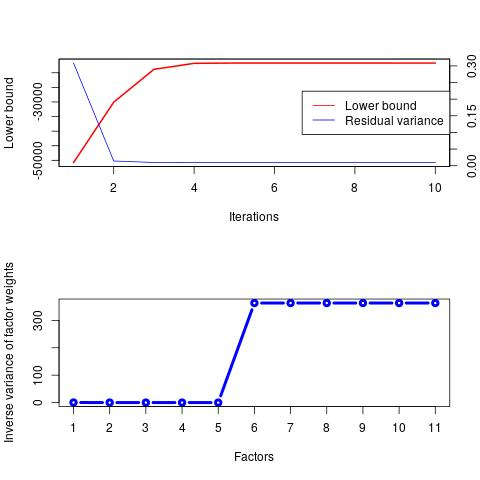

>>> Peer_example_data_diagnosis_plot.jpeg:

bash: ./Peer_example_data_diagnosis_plot.jpeg: Permission denied


In [47]:
%preview Peer_example_data_diagnosis_plot.jpeg 

## Reference:
* Codes are adapted from [here](https://github.com/RTIInternational/biocloud_docker_tools/blob/master/peer/v1.3/run_peer.R)
* GTEX recommandation of PEER factors is [here](https://gtexportal.org/home/documentationPage)
* Examples by PEER is at [github](https://github.com/PMBio/peer/wiki/Tutorial)